In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip

--2020-12-22 06:35:49--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘apple2orange.zip’

apple2orange.zip    100%[===================>]  74.82M  32.9MB/s    in 2.3s    

2020-12-22 06:35:52 (32.9 MB/s) - ‘apple2orange.zip’ saved [78456409/78456409]



In [5]:
!unzip apple2orange.zip

Archive:  apple2orange.zip
   creating: apple2orange/
   creating: apple2orange/trainA/
  inflating: apple2orange/trainA/n07740461_6908.jpg  
  inflating: apple2orange/trainA/n07740461_7635.jpg  
  inflating: apple2orange/trainA/n07740461_586.jpg  
  inflating: apple2orange/trainA/n07740461_9813.jpg  
  inflating: apple2orange/trainA/n07740461_6835.jpg  
  inflating: apple2orange/trainA/n07740461_2818.jpg  
  inflating: apple2orange/trainA/n07740461_2918.jpg  
  inflating: apple2orange/trainA/n07740461_1213.jpg  
  inflating: apple2orange/trainA/n07740461_2476.jpg  
  inflating: apple2orange/trainA/n07740461_13596.jpg  
  inflating: apple2orange/trainA/n07740461_4093.jpg  
  inflating: apple2orange/trainA/n07740461_14738.jpg  
  inflating: apple2orange/trainA/n07740461_6477.jpg  
  inflating: apple2orange/trainA/n07740461_11356.jpg  
  inflating: apple2orange/trainA/n07740461_7594.jpg  
  inflating: apple2orange/trainA/n07740461_5119.jpg  
  inflating: apple2orange/trainA/n07740461_104

In [4]:
!ls apple2orange

testA  testB  trainA  trainB


In [5]:
import glob
apples = glob.glob('apple2orange/trainA/*.jpg')
oranges = glob.glob('apple2orange/trainB/*.jpg')
train = apples + oranges
test = glob.glob('apple2orange/testA/*.jpg') + glob.glob('apple2orange/testB/*.jpg')

In [6]:
len(train), len(test)

(2014, 514)

In [7]:
import cv2
for file in test[:10]:
    map = cv2.imread(file)
    print (map.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


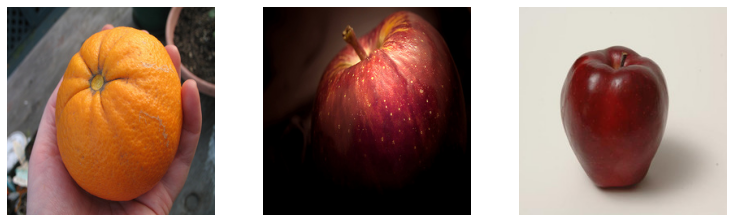

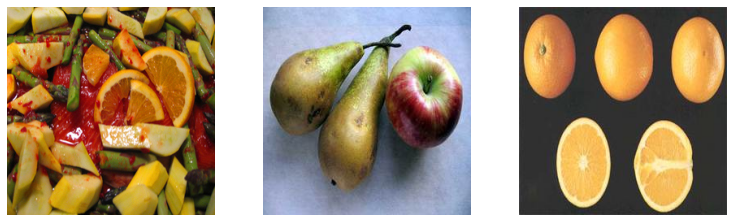

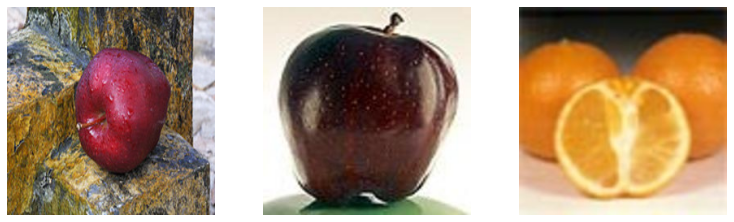

In [8]:
for k in range(3):
    plt.figure(figsize=(13, 13))
    for j in range(3):
        file = np.random.choice(train)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(330 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

Input Images


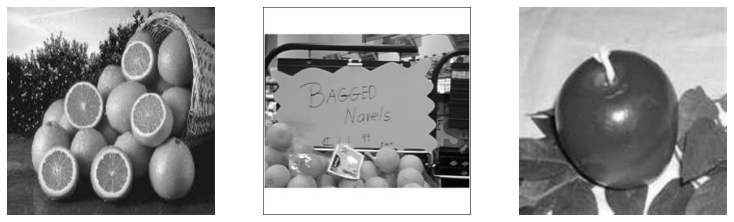

Output Images


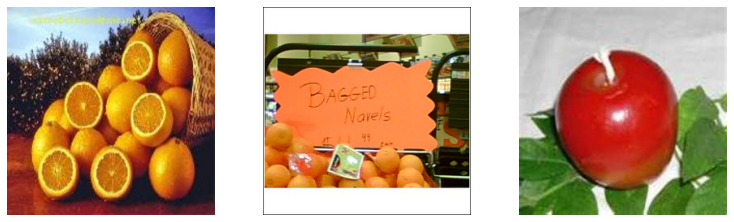

In [9]:
images = []
for j in range(3):
    file = np.random.choice(train)
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

print ('Input Images')
plt.figure(figsize=(13, 13))
for j, img in enumerate(images):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.subplot(330 + 1 + j)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    #plt.title(trainY[i])
plt.show()

print ('Output Images')
plt.figure(figsize=(13, 13))
for j, img in enumerate(images):
    plt.subplot(330 + 1 + j)
    plt.imshow(img)
    plt.axis('off')
    #plt.title(trainY[i])
plt.show()

# Generator Model (U-Net Like)

In [10]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [11]:
source_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 1))

e1 = encoder_layer(source_image_input, 64, bn=False)#64
e2 = encoder_layer(e1, 64)#128
e3 = encoder_layer(e2, 64)#256
e4 = encoder_layer(e3, 128)#512
e5 = encoder_layer(e4, 128)#512
e6 = encoder_layer(e5, 128)#512
e7 = encoder_layer(e6, 128)#512

bottle_neck = tensorflow.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same')(e7)
b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

d1 = decoder_layer(b, e7, 128)#512
d2 = decoder_layer(d1, e6, 128)#512
d3 = decoder_layer(d2, e5, 128)#512
d4 = decoder_layer(d3, e4, 128)#512
d5 = decoder_layer(d4, e3, 64)#256
d6 = decoder_layer(d5, e2, 64)#128
d7 = decoder_layer(d6, e1, 64)#64

decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)

generator_network = tensorflow.keras.models.Model(inputs=source_image_input, outputs=translated_image)
print (generator_network.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1088        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   65600       leaky_re_lu[0][0]                
______________________________________________________________________________________________

# Discriminator Network

In [12]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

In [14]:
source_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 1))
target_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

combined = tensorflow.keras.layers.Concatenate(axis=-1)([source_image_input, target_image_input])

x = my_conv_layer(combined, 64, bn=False)#64
x = my_conv_layer(x, 64)#128
x = my_conv_layer(x, 128)#256
x = my_conv_layer(x, 256)#512

patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=[source_image_input, target_image_input], outputs=patch_features)
print (discriminator_network.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 256, 256, 4)  0           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 128, 64) 4160        concatenate_8[0][0]        

In [15]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# pix2pix

In [16]:
discriminator_network.trainable=False

g_output = generator_network(source_image_input)
d_output = discriminator_network([source_image_input, g_output])

pix2pix = tensorflow.keras.models.Model(inputs=source_image_input, outputs=[d_output, g_output])
pix2pix.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 256, 256, 3)  3684099     input_4[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 16, 16, 1)    731393      input_4[0][0]                    
                                                                 model[0][0]                      
Total params: 4,415,492
Trainable params: 3,681,411
Non-trainable params: 734,081
__________________________________________________________________________________________________


# Compiling Models

In [17]:
pix2pix.compile(loss=['mse', 'mae'], optimizer=adam_optimizer, loss_weights=[1, 100])

# Define Data Generators

In [21]:
def get_predictions(input_sample, generator_network):
    input_sample = np.expand_dims(input_sample, axis=0)
    output_sample = generator_network.predict_on_batch(input_sample)
    return output_sample

def get_generated_samples(generator_network, imgs_input):
    generated_samples = generator_network.predict_on_batch(imgs_input)
    return generated_samples

def get_img_samples(batch_size):
    random_files = np.random.choice(train, size=batch_size)
    imgs_input = []
    imgs_output = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        black_and_white = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        black_and_white = np.expand_dims(black_and_white, axis=-1)
        imgs_input.append((black_and_white-127.5)/127.5)
        imgs_output.append((img-127.5)/127.5)
    imgs_input = np.array(imgs_input)
    imgs_output = np.array(imgs_output)
    return imgs_input, imgs_output

def show_generator_results(generator_network):
    images = []
    for j in range(3):
        file = np.random.choice(test)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    print ('Input Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        black_and_white = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        plt.subplot(330 + 1 + j)
        plt.imshow(black_and_white, cmap='gray')
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Predicted Output Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        black_and_white = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        black_and_white = (black_and_white-127.5)/127.5
        output = get_predictions(black_and_white, generator_network)[0]
        output = (output+1.0)/2.0
        plt.subplot(330 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Real Output Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(330 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training GAN

In [22]:
len(train)

2014

Input Images


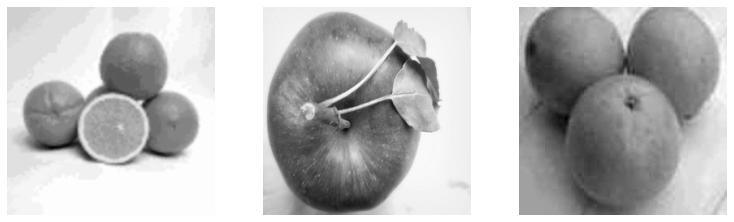

Predicted Output Images


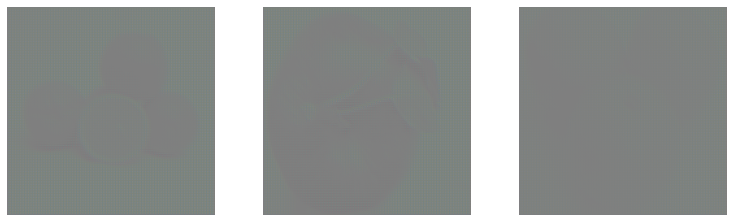

Real Output Images


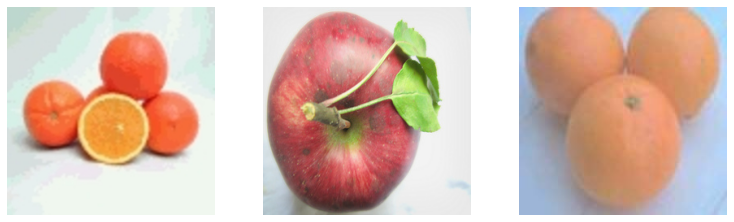

Epoch:0, Step:0, D-Loss:2.810, D-Acc:47.664, G-Loss:65.759
Epoch:0, Step:10, D-Loss:0.626, D-Acc:53.652, G-Loss:27.292
Epoch:1, Step:0, D-Loss:0.424, D-Acc:52.875, G-Loss:22.069
Epoch:1, Step:10, D-Loss:0.375, D-Acc:51.496, G-Loss:22.323
Epoch:2, Step:0, D-Loss:0.360, D-Acc:49.445, G-Loss:20.862
Epoch:2, Step:10, D-Loss:0.331, D-Acc:49.316, G-Loss:19.165
Epoch:3, Step:0, D-Loss:0.310, D-Acc:49.117, G-Loss:18.850
Epoch:3, Step:10, D-Loss:0.297, D-Acc:49.539, G-Loss:18.094
Epoch:4, Step:0, D-Loss:0.300, D-Acc:48.461, G-Loss:17.526
Epoch:4, Step:10, D-Loss:0.288, D-Acc:48.816, G-Loss:17.186
Epoch:5, Step:0, D-Loss:0.294, D-Acc:48.613, G-Loss:16.564
Epoch:5, Step:10, D-Loss:0.300, D-Acc:49.559, G-Loss:16.015
Epoch:6, Step:0, D-Loss:0.393, D-Acc:47.668, G-Loss:16.302
Epoch:6, Step:10, D-Loss:0.278, D-Acc:50.855, G-Loss:14.962
Epoch:7, Step:0, D-Loss:0.270, D-Acc:48.941, G-Loss:15.477
Epoch:7, Step:10, D-Loss:0.273, D-Acc:49.012, G-Loss:15.623
Epoch:8, Step:0, D-Loss:0.284, D-Acc:48.219, G-L

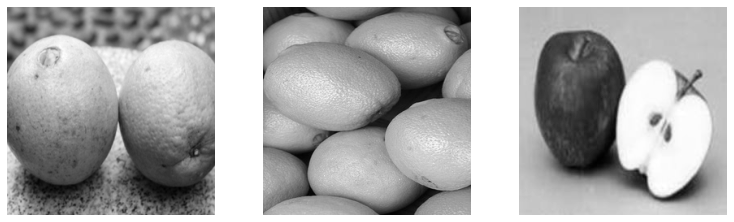

Predicted Output Images


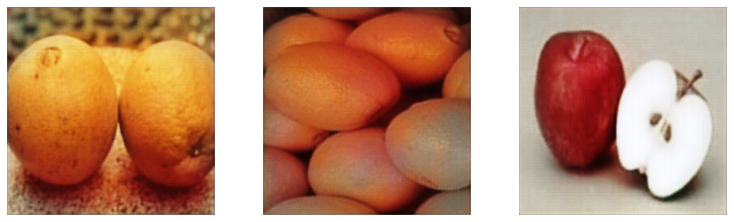

Real Output Images


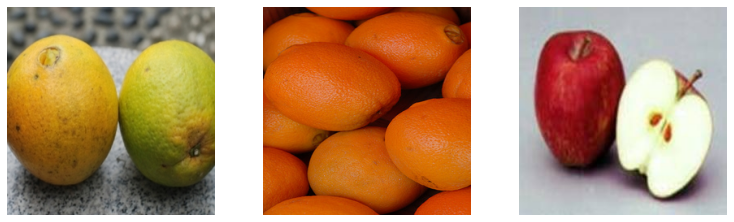

Epoch:10, Step:0, D-Loss:0.294, D-Acc:49.254, G-Loss:12.942
Epoch:10, Step:10, D-Loss:0.264, D-Acc:48.539, G-Loss:13.784
Epoch:11, Step:0, D-Loss:0.278, D-Acc:49.875, G-Loss:13.533
Epoch:11, Step:10, D-Loss:0.270, D-Acc:48.301, G-Loss:12.328
Epoch:12, Step:0, D-Loss:0.271, D-Acc:48.734, G-Loss:12.857
Epoch:12, Step:10, D-Loss:0.423, D-Acc:49.559, G-Loss:12.314
Epoch:13, Step:0, D-Loss:0.264, D-Acc:48.426, G-Loss:13.026
Epoch:13, Step:10, D-Loss:0.261, D-Acc:49.957, G-Loss:11.198
Epoch:14, Step:0, D-Loss:0.277, D-Acc:50.164, G-Loss:11.796
Epoch:14, Step:10, D-Loss:0.260, D-Acc:49.531, G-Loss:11.985
Epoch:15, Step:0, D-Loss:0.264, D-Acc:50.230, G-Loss:12.492
Epoch:15, Step:10, D-Loss:0.323, D-Acc:49.586, G-Loss:10.342
Epoch:16, Step:0, D-Loss:0.262, D-Acc:49.570, G-Loss:10.094
Epoch:16, Step:10, D-Loss:0.257, D-Acc:51.523, G-Loss:10.282
Epoch:17, Step:0, D-Loss:0.259, D-Acc:48.383, G-Loss:11.085
Epoch:17, Step:10, D-Loss:0.263, D-Acc:48.059, G-Loss:9.946
Epoch:18, Step:0, D-Loss:0.255, D

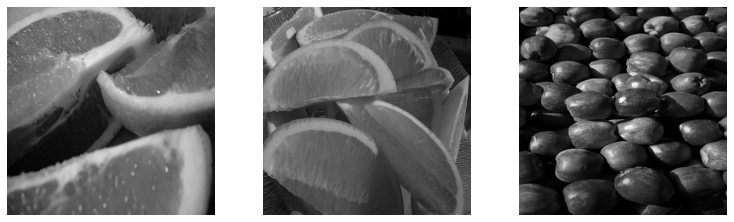

Predicted Output Images


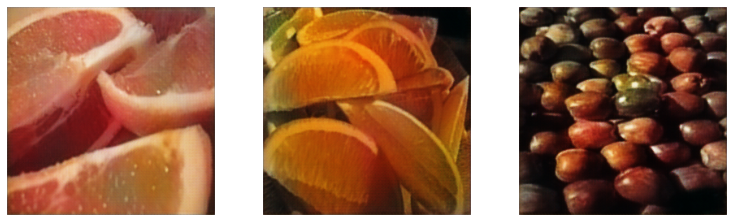

Real Output Images


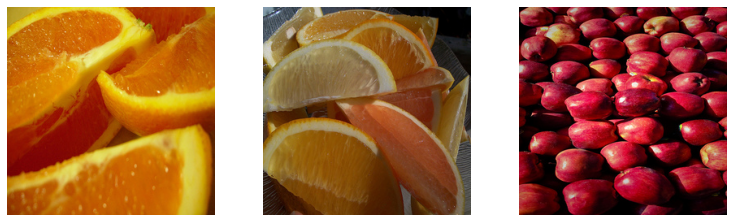

Epoch:20, Step:0, D-Loss:0.252, D-Acc:53.172, G-Loss:10.431
Epoch:20, Step:10, D-Loss:0.278, D-Acc:45.656, G-Loss:11.031
Epoch:21, Step:0, D-Loss:0.261, D-Acc:48.969, G-Loss:10.955
Epoch:21, Step:10, D-Loss:0.237, D-Acc:57.840, G-Loss:9.780
Epoch:22, Step:0, D-Loss:0.276, D-Acc:57.203, G-Loss:9.395
Epoch:22, Step:10, D-Loss:0.408, D-Acc:55.418, G-Loss:9.397
Epoch:23, Step:0, D-Loss:0.254, D-Acc:55.289, G-Loss:9.916
Epoch:23, Step:10, D-Loss:0.270, D-Acc:51.023, G-Loss:8.873
Epoch:24, Step:0, D-Loss:0.181, D-Acc:77.152, G-Loss:9.196
Epoch:24, Step:10, D-Loss:0.373, D-Acc:52.266, G-Loss:8.667
Epoch:25, Step:0, D-Loss:0.173, D-Acc:75.992, G-Loss:8.356
Epoch:25, Step:10, D-Loss:0.338, D-Acc:59.078, G-Loss:9.044
Epoch:26, Step:0, D-Loss:0.134, D-Acc:84.945, G-Loss:9.596
Epoch:26, Step:10, D-Loss:0.160, D-Acc:77.496, G-Loss:9.400
Epoch:27, Step:0, D-Loss:0.090, D-Acc:94.020, G-Loss:8.452
Epoch:27, Step:10, D-Loss:0.098, D-Acc:92.469, G-Loss:7.968
Epoch:28, Step:0, D-Loss:0.175, D-Acc:79.086,

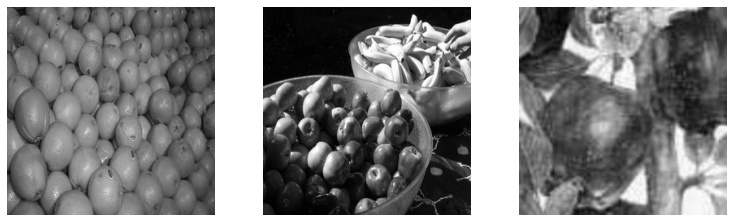

Predicted Output Images


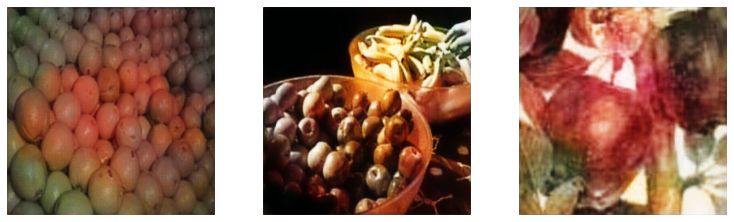

Real Output Images


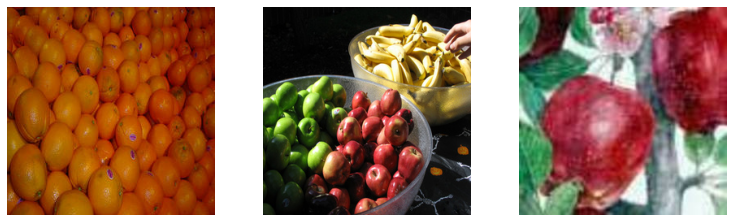

Epoch:30, Step:0, D-Loss:0.056, D-Acc:97.902, G-Loss:8.664
Epoch:30, Step:10, D-Loss:0.055, D-Acc:96.535, G-Loss:8.084
Epoch:31, Step:0, D-Loss:0.062, D-Acc:97.031, G-Loss:8.470
Epoch:31, Step:10, D-Loss:0.055, D-Acc:98.066, G-Loss:8.517
Epoch:32, Step:0, D-Loss:0.069, D-Acc:94.871, G-Loss:7.980
Epoch:32, Step:10, D-Loss:0.044, D-Acc:98.543, G-Loss:7.747
Epoch:33, Step:0, D-Loss:0.078, D-Acc:93.414, G-Loss:8.466
Epoch:33, Step:10, D-Loss:0.026, D-Acc:99.750, G-Loss:7.677
Epoch:34, Step:0, D-Loss:0.087, D-Acc:90.352, G-Loss:6.940
Epoch:34, Step:10, D-Loss:0.082, D-Acc:92.875, G-Loss:7.926
Epoch:35, Step:0, D-Loss:0.028, D-Acc:99.734, G-Loss:7.564
Epoch:35, Step:10, D-Loss:0.043, D-Acc:99.590, G-Loss:7.548
Epoch:36, Step:0, D-Loss:0.053, D-Acc:97.555, G-Loss:8.267
Epoch:36, Step:10, D-Loss:0.053, D-Acc:99.184, G-Loss:7.437
Epoch:37, Step:0, D-Loss:0.038, D-Acc:99.375, G-Loss:7.449
Epoch:37, Step:10, D-Loss:0.022, D-Acc:99.816, G-Loss:7.490
Epoch:38, Step:0, D-Loss:0.017, D-Acc:99.949, G-

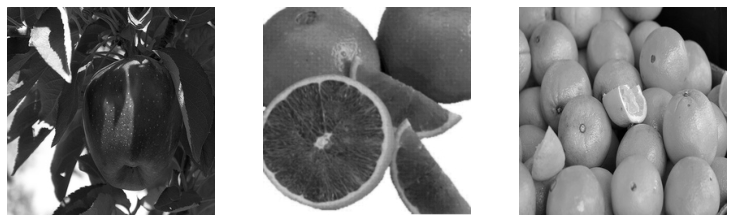

Predicted Output Images


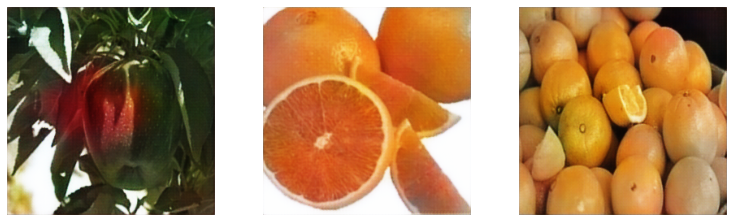

Real Output Images


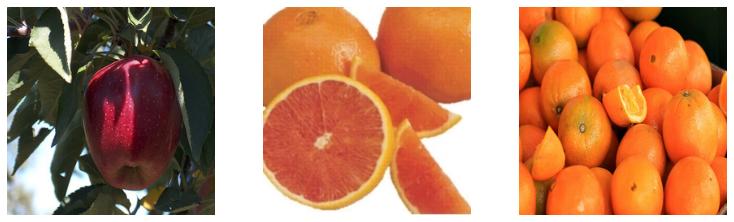

Epoch:40, Step:0, D-Loss:0.045, D-Acc:99.207, G-Loss:7.533
Epoch:40, Step:10, D-Loss:0.023, D-Acc:99.813, G-Loss:7.168
Epoch:41, Step:0, D-Loss:0.020, D-Acc:99.789, G-Loss:7.595
Epoch:41, Step:10, D-Loss:0.026, D-Acc:99.836, G-Loss:7.754
Epoch:42, Step:0, D-Loss:0.018, D-Acc:99.910, G-Loss:7.205
Epoch:42, Step:10, D-Loss:0.013, D-Acc:99.957, G-Loss:6.543
Epoch:43, Step:0, D-Loss:0.024, D-Acc:99.980, G-Loss:7.678


KeyboardInterrupt: ignored

In [23]:
epochs = 500
batch_size = 100
steps = 20

for i in range(0, epochs):
    if (i%10 == 0):
        op = show_generator_results(generator_network)
    for j in range(steps):
        imgs_input, imgs_output = get_img_samples(batch_size=batch_size//2)
        generated_imgs_output = get_generated_samples(generator_network, imgs_input)

        fake_patch = np.zeros((batch_size//2, 16, 16, 1))
        real_patch = np.ones((batch_size//2, 16, 16, 1))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d1 = discriminator_network.train_on_batch([imgs_input, imgs_output], real_patch)
        loss_d2 = discriminator_network.train_on_batch([imgs_input, generated_imgs_output], fake_patch)
        
        loss_d = (np.add(loss_d1, loss_d2))/2.0
        
        
        imgs_input, imgs_output = get_img_samples(batch_size=batch_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g, _, _ = pix2pix.train_on_batch(imgs_input, [real_patch, imgs_output])
        
        if j%10 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))   

In [24]:
generator_network.save("/content/gdrive/MyDrive/GAN_datasets/black_n_white_to_color")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GAN_datasets/black_n_white_to_color/assets


Input Images


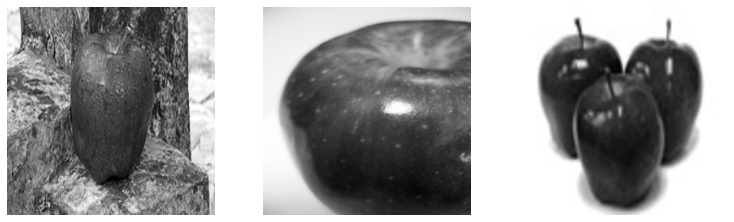

Predicted Output Images


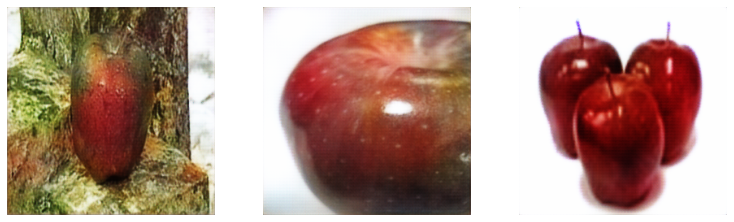

Real Output Images


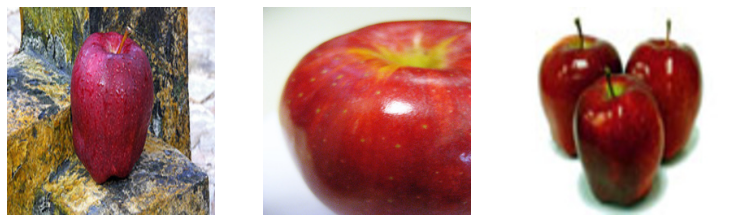

Input Images


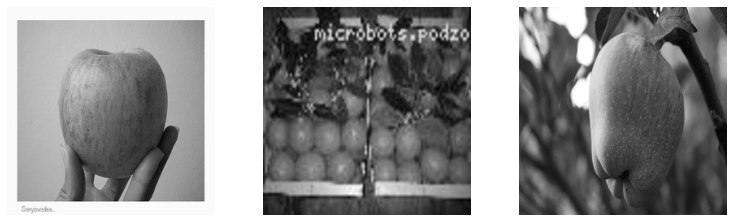

Predicted Output Images


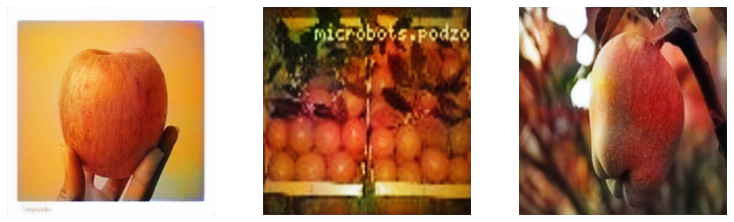

Real Output Images


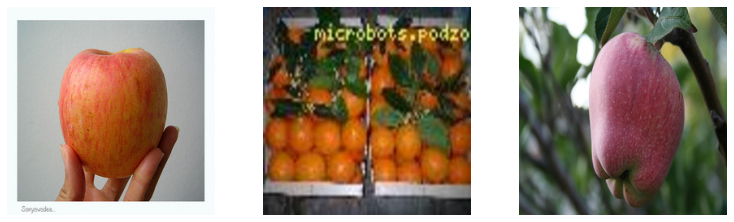

Input Images


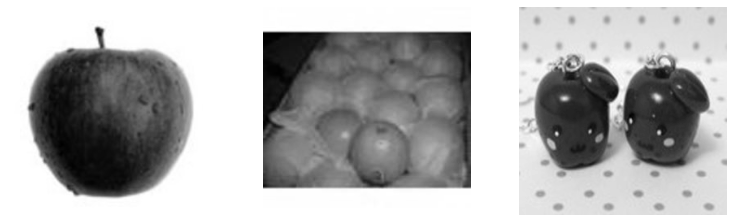

Predicted Output Images


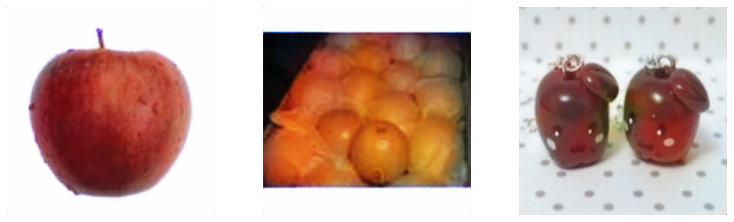

Real Output Images


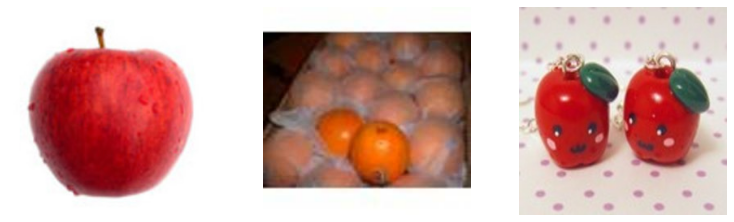

Input Images


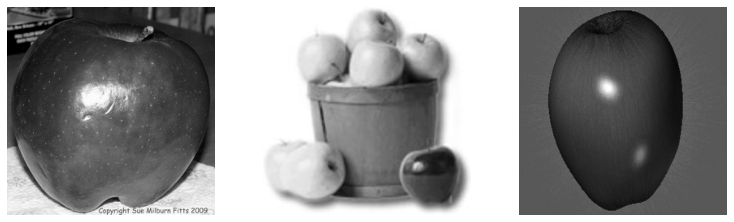

Predicted Output Images


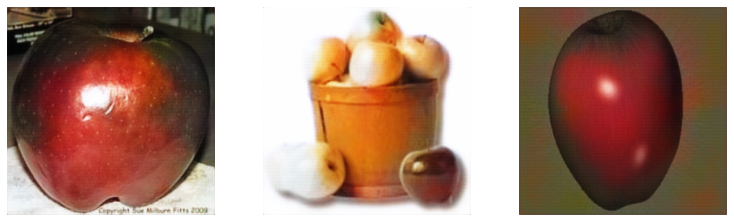

Real Output Images


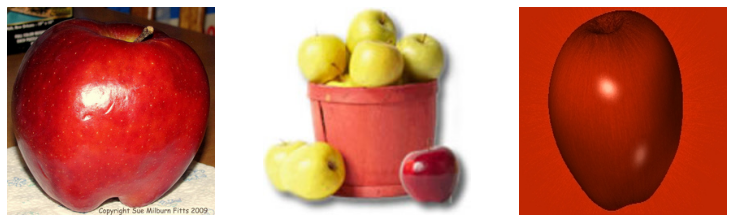

Input Images


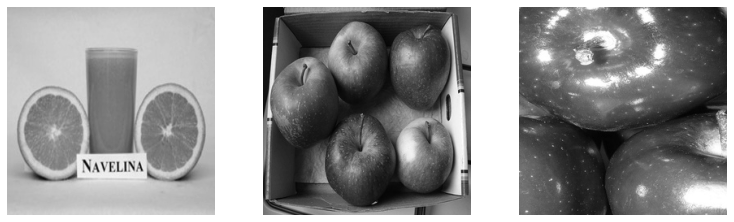

Predicted Output Images


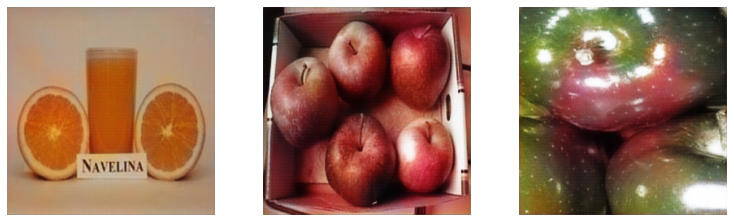

Real Output Images


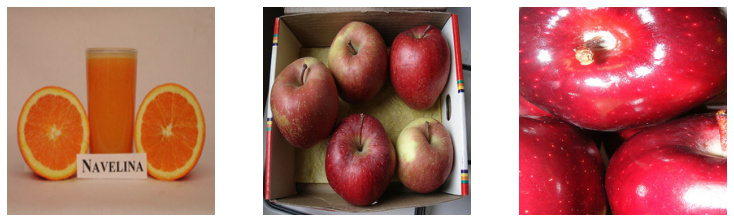

In [25]:
#Checkout few results
for i in range(5):
    show_generator_results(generator_network)